In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARMA

plt.style.use('ggplot')

%matplotlib inline

In [2]:
path_ts = 'csse_covid_19_data/csse_covid_19_time_series/'
path_dr = 'csse_covid_19_data/csse_covid_19_daily_reports/'

In [3]:
confirmed = pd.read_csv(os.path.join(path_ts,'time_series_19-covid-Confirmed.csv'))
deaths = pd.read_csv(os.path.join(path_ts,'time_series_19-covid-Deaths.csv'))
recovered = pd.read_csv(os.path.join(path_ts,'time_series_19-covid-Recovered.csv'))

In [4]:
confirmed['Flag'] = 'confirmed'
deaths['Flag'] = 'deaths'
recovered['Flag'] = 'recovered'

df_merged = pd.concat([confirmed,deaths,recovered])
cols = df_merged.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_merged = df_merged[cols]

country_geopostions = df_merged.groupby('Country/Region').agg({'Lat':'mean','Long':'mean'}).reset_index()
df = df_merged.drop(['Province/State','Lat','Long'], axis = 1) \
                                    .groupby(['Country/Region','Flag']).sum().reset_index()
date_cols = [col for col in df.columns if '20' in col]
df = country_geopostions.merge(df, how = 'left', on = 'Country/Region')

In [5]:
df_world = df.groupby('Flag')[date_cols].sum()
df_world['Country/Region'] = 'World'
df_world.reset_index(inplace = True)

df_world_without_china = df[df['Country/Region']!='China'].groupby('Flag')[date_cols].sum()
df_world_without_china['Country/Region'] = 'World_without_China'
df_world_without_china.reset_index(inplace = True)

df = pd.concat([df, df_world, df_world_without_china], axis = 0, ignore_index=True)

In [6]:
df[df['Country/Region']=='China']

,Country/Region,Lat,Long,Flag,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20
87,China,32.828385,111.649082,confirmed,548,643,920,1406,2075,2877,...,80823,80860,80887,80921,80932,80945,80977,81003,81033,81058
88,China,32.828385,111.649082,deaths,17,18,26,42,56,82,...,3100,3123,3139,3161,3172,3180,3193,3203,3217,3230
89,China,32.828385,111.649082,recovered,28,30,36,39,49,58,...,57388,58804,60181,61644,62901,64196,65660,67017,67910,68798


# Additional Features

In [7]:
europe=[]
with open('europe.csv') as f:
    for line in f:
        europe.append(line.split()[0])

df['Europe'] = np.where(df['Country/Region'].isin(europe),1,0)

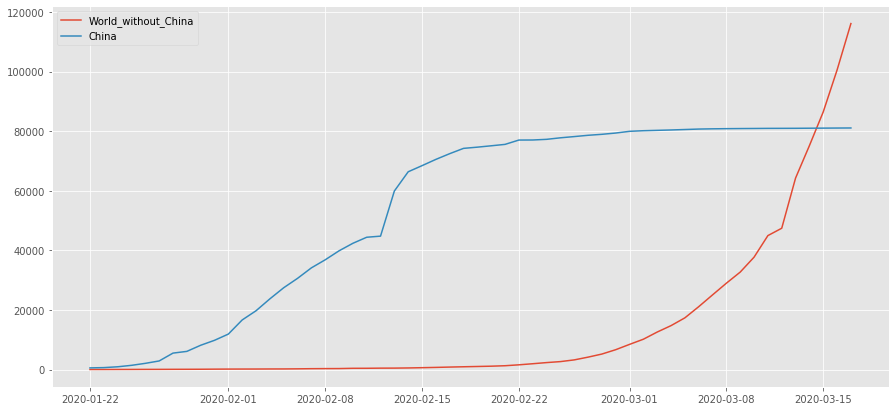

In [22]:
sort_list = ['China','World_without_China']
top_countries = df[(df['Flag']=='confirmed')&(df['Country/Region'].isin(sort_list))] \
                .sort_values(by=date_cols[-1], ascending=False).iloc[:7]

top_countries.index = top_countries['Country/Region']
top_countries = top_countries[date_cols].T
top_countries.index = pd.to_datetime(top_countries.index, format = '%m/%d/%y')
#top_countries=top_countries.loc['2020-02-01':]

plt.figure(figsize=(15,7))
plt.plot(top_countries)
plt.legend(top_countries.columns.values);

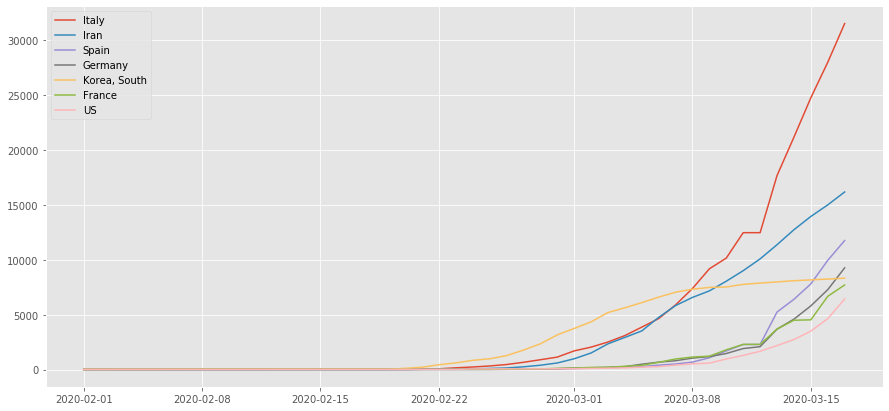

In [8]:
sort_list = ['World','China','World_without_China']
top_countries = df[(df['Flag']=='confirmed')&(~df['Country/Region'].isin(sort_list))] \
                .sort_values(by=date_cols[-1], ascending=False).iloc[:7]

top_countries.index = top_countries['Country/Region']
top_countries = top_countries[date_cols].T
top_countries.index = pd.to_datetime(top_countries.index, format = '%m/%d/%y')
top_countries=top_countries.loc['2020-02-01':]

plt.figure(figsize=(15,7))
plt.plot(top_countries)
plt.legend(top_countries.columns.values);

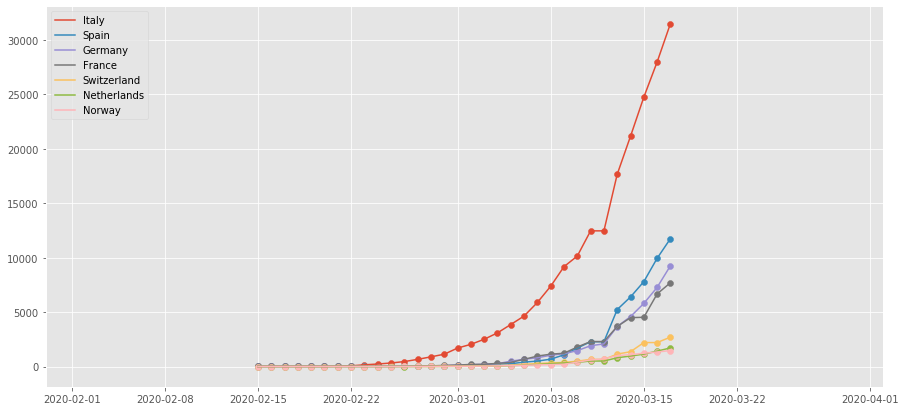

In [9]:
europe_countries = df[(df['Flag']=='confirmed')&(df['Europe'] == 1)] \
                .sort_values(by=date_cols[-1], ascending=False).iloc[:7]

europe_countries.index = europe_countries['Country/Region']
europe_countries = europe_countries[date_cols].T
europe_countries.index = pd.to_datetime(europe_countries.index, format = '%m/%d/%y')

europe_countries=europe_countries.loc['2020-02-15':]
plt.figure(figsize=(15,7))
for country in europe_countries.columns:
    plt.scatter(europe_countries[country].index, europe_countries[country])
    plt.plot(europe_countries[country])

plt.legend(europe_countries.columns.values, loc = 'upper left')
plt.show();

# Analysis

In [10]:
class Country:
    def __init__(self, name):
        self.name = name
        self.dataframe = df[df['Country/Region'] == self.name]
        self.dataframe.index = self.dataframe['Flag']
        self.dataframe = self.dataframe[date_cols].T
        self.dataframe.index = pd.to_datetime(self.dataframe.index, format = '%m/%d/%y')
        
        #additional dataframes
        self.dataframe_daily = self.dataframe.diff().dropna()
        self.dataframe_log = self.dataframe.apply(np.log1p)  
        self.dataframe_log_diff = self.dataframe_log.diff().dropna()      
        
    def get_predictions(self, pred_range = 3, Flag = 'confirmed'):
        self.Flag=Flag
        train = self.dataframe_log[[Flag]].diff().dropna()
        model = ARMA(train, order = (0,3))
        model_fit = model.fit()
        preds = model_fit.predict(len(train), len(train)+pred_range)
        last_known = self.dataframe_log[Flag].dropna()[-1]
        predictions = preds.copy()
        for i in range(len(preds)):
            predictions[i] = np.exp(last_known+preds[i])
            last_known+=preds[i]

        self.predictions=predictions
    
    def plot_data(self, type = 'cumm'):
        if type == 'daily':
            data = self.dataframe_daily
        elif type == 'log':
            data = self.dataframe_log
        else:
            data = self.dataframe
            
        plt.figure(figsize = (15,7))
        
        plt.scatter(x = data.index, y = data['confirmed'])
        sns.lineplot(x = data.index, y = data['confirmed'], label = 'confirmed')
        plt.scatter(x = data.index, y = data['deaths'])
        sns.lineplot(x = data.index, y = data['deaths'], label = 'deaths')
        plt.scatter(x = data.index, y = data['recovered'])
        sns.lineplot(x = data.index, y = data['recovered'], label = 'recovered')
        
        plt.title(f'COVID-19 {type}-cases in {self.name}')
        plt.ylabel('cases')
        plt.xticks(rotation=70)
        plt.legend(loc='upper left')
        plt.show();
  
    def plot_predictions(self):
        plt.figure(figsize=(8,10))
        plt.scatter(x = self.dataframe.index, y = self.dataframe[[self.Flag]])
        plt.plot(self.dataframe[[self.Flag]], label = 'Known')
        plt.scatter(x = self.predictions.index, y = self.predictions.values)
        plt.plot(self.predictions, label = 'Forecasting')

        for i,pred in enumerate(self.predictions):
            plt.annotate(round(pred),(self.predictions.index[i],pred))

        plt.xticks(rotation=70)
        plt.xlabel('cases')
        plt.title(f"COVID-19 {self.Flag} Predictions")
        plt.legend(loc='upper left')
        plt.show;

/Users/sarzhannurzhan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


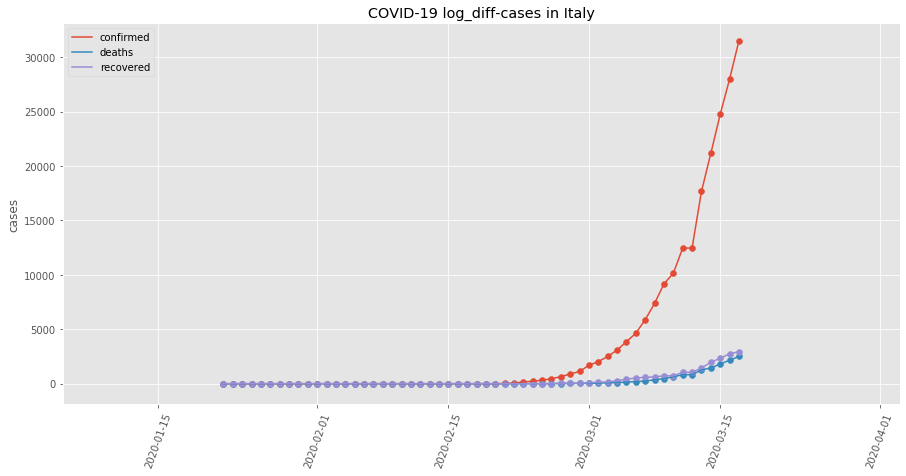

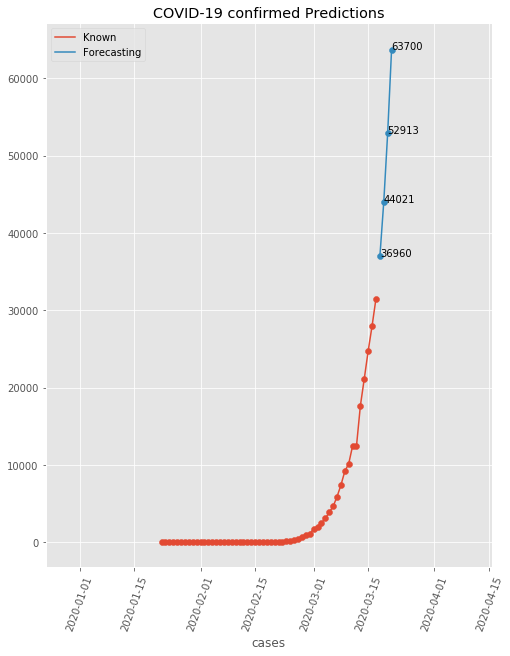

In [23]:
test = Country('Italy')
test.get_predictions(Flag='confirmed')
test.plot_data(type='log_diff')
test.plot_predictions()

In [12]:
df[df['Country/Region']=='Kazakhstan']

,Country/Region,Lat,Long,Flag,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,Europe
225,Kazakhstan,48.0196,66.9237,confirmed,0,0,0,0,0,0,...,0,0,0,0,4,6,9,10,33,1
226,Kazakhstan,48.0196,66.9237,deaths,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
227,Kazakhstan,48.0196,66.9237,recovered,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
pred_range = 3 
Flag = 'confirmed'


train = test.dataframe_daily[[Flag]].diff().dropna()
model = ARMA(train, order = (0,3))
model_fit = model.fit()
preds = model_fit.predict(len(train), len(train)+pred_range)
last_known = test.dataframe_log[Flag].dropna()[-1]
predictions = preds.copy()
for i in range(len(preds)):
    predictions[i] = (last_known+preds[i])
    last_known+=preds[i]

predictions

/Users/sarzhannurzhan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2020-03-18     5.442448
2020-03-19     3.155867
2020-03-20   -15.169343
2020-03-21   -15.035440
Freq: D, dtype: float64

# trash

In [14]:
min = 10e6
min_i = 0
for i in range(40):
    df_wl = Country('World_without_China').dataframe_log[['confirmed']]
    df_ch = Country('China').dataframe_log[['confirmed']]
    df_wl['confirmed_shift']=df_ch['confirmed'].shift(periods=i)
    df_wl.dropna(inplace=True)
    diff = np.sqrt(np.mean((df_wl['confirmed']-df_wl['confirmed_shift'])**2))
    if diff < min:
        min=diff
        min_i=i
print(f'Best shift for comparison World with China is {min_i} days')

Best shift for comparison World with China is 30 days


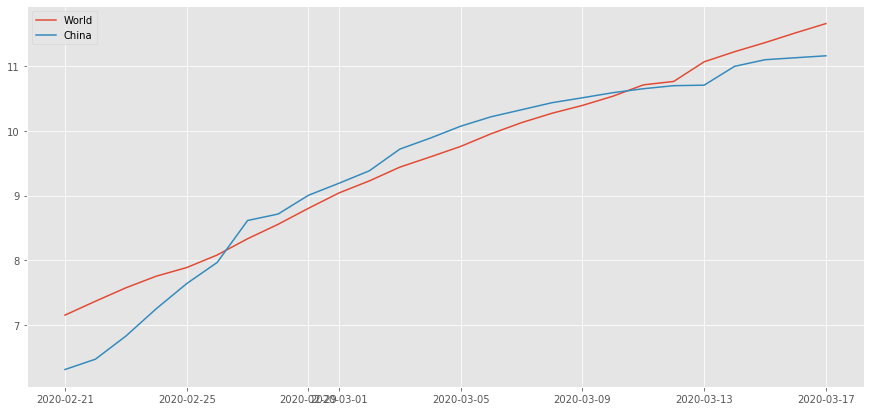

In [15]:
df_wl = Country('World_without_China').dataframe_log[['confirmed']]
df_ch = Country('China').dataframe_log[['confirmed']]

df_wl['confirmed_shift']=df_ch['confirmed'].shift(periods=min_i)
df_wl.dropna(inplace=True)

plt.figure(figsize=(15,7))
plt.plot(df_wl['confirmed'], label='World')
plt.plot(df_wl['confirmed_shift'], label='China')

plt.legend();

In [16]:
test = world_wc.dataframe_log[['confirmed']]
indices = pd.date_range(start='2020-03-14', end='2020-03-17')
test = test.append(pd.DataFrame(index=indices))

test['shift'] = test['confirmed'].shift(periods=1)
test['diff'] = test['shift'].diff(periods=1)
test['rolling_mean'] = test['diff'].rolling(5).mean()
test['rolling_std'] = test['diff'].rolling(5).std()
test['predicted'] = test['rolling_mean']+test['shift']

plt.figure(figsize=(15,7))
plt.plot(test[['confirmed','predicted']]);

NameError: name 'world_wc' is not defined